![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Marty McFly |
<b>Student-nr</b>: C25 |
<b>Date</b>: June 12, 2015
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment are just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [22]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook
import pickle

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of synthetic similarity scores of four different biometric systems. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (impostor scores). The data can be found in the .csv files in the `./data/` subfolder. 

In this code example we will compare the performance of four biometric systems. These systems are referred to as `system1`, `system2`, `system3` and `system4` respectively in both code and text. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
For each question, make sure to <b> compare the results for the different systems</b>!!! Mention which system performs the best/worst and why.</div>

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for all the systems: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [23]:
# STEP 1: loading the similarity matrices for the four systems
with open('./data/system1_similarity_matrix.csv','rb') as f:
    system1_similarity_matrix = pickle.load(f)
with open('./data/system2_similarity_matrix.csv','rb') as f:
    system2_similarity_matrix = pickle.load(f)
with open('./data/system3_similarity_matrix.csv','rb') as f:
    system3_similarity_matrix = pickle.load(f)
with open('./data/system4_similarity_matrix.csv','rb') as f:
    system4_similarity_matrix = pickle.load(f)


In [24]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
def sim2scores(similarity_matrix):
    # use .values to access as numpy array
    np_similarity_matrix = similarity_matrix

    # grab elements on the diagonal
    genuine_scores = np.diag(np_similarity_matrix)

    # mask elements that are on the diagonal, retain non-diagonal elements
    imposter_scores =  np_similarity_matrix[~np.eye(np_similarity_matrix.shape[0],dtype=bool)]

    # store in one single list of scores as required for the classification validation procedures
    scores = np.append(np.array(genuine_scores), np.array(imposter_scores))

    # normalize to [0,1] range, 0 corresponding to minimal similarity
    scores = (scores - scores.min())/(scores.max()-scores.min())

    ## add the genuine and imposter labels

    # tag genuine combinations as label 1 and imposter combinations as 0

    genuine_id = np.zeros_like(scores)
    genuine_id[0:genuine_scores.shape[0]] = 1

    return(genuine_id, scores)


system1_genuine_id, system1_scores = sim2scores(system1_similarity_matrix)
system2_genuine_id, system2_scores = sim2scores(system2_similarity_matrix)
system3_genuine_id, system3_scores = sim2scores(system3_similarity_matrix)
system4_genuine_id, system4_scores = sim2scores(system4_similarity_matrix)

<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot for the four systems.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot. Which system performs the best based on this plot?</li>
  <li>Which system corresponds to which of the following descriptions?</li>
  <ol type = 'A'>
    <li> small inter-user distance, small intra-user variation </li>
    <li> small inter-user similarity, small intra-user variation </li>
    <li> large inter-user similarity, large intra-user variation </li>
    <li> large inter-user distance, large intra-user variation </li>
  </ol>
</ul>  
</div>

In [25]:
#### Example of separating genuine and impostor scores
def separateScores(genuineID, scores):
    genuineScores = scores[genuineID == 1]
    impostorScores = scores[genuineID == 0]
    return genuineScores, impostorScores

# Create systems tuples
systems = [("skyblue", "--", system1_genuine_id, system1_scores),
           ("red", ":", system2_genuine_id, system2_scores),
           ("#D3C710", "--", system3_genuine_id, system3_scores),
           ("black", ":", system4_genuine_id, system4_scores)]

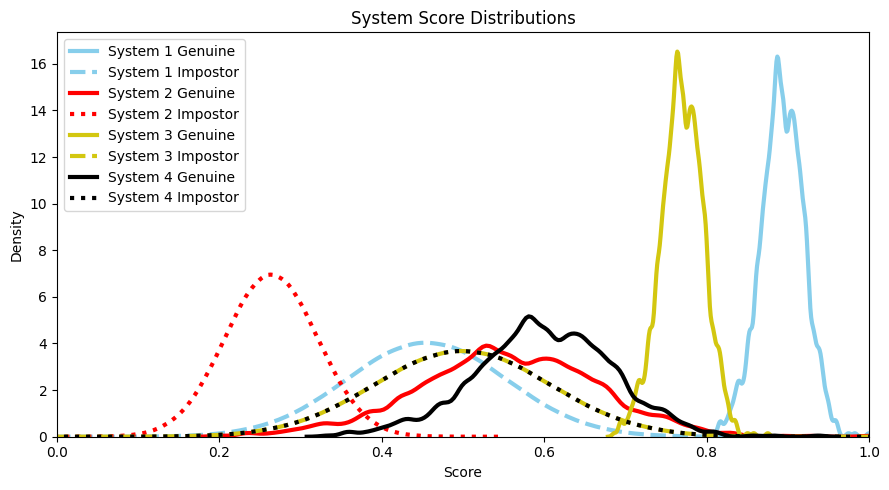

In [19]:
"""Plot the genuine and imposter score distributions."""
# Seaborn for kde plotting
import seaborn as sns
# Define the figure size and layout
plt.figure(figsize=(9, 5)) 
# Loop through each system, creating a subplot for each
for i, (color, style, genuineID, scores) in enumerate(systems):
    genuineScores, impostorScores = separateScores(genuineID, scores)    
    # Plot KDEs for genuine and impostor scores
    sns.kdeplot(genuineScores, label=f'System {i+1} Genuine', color=color, linewidth=3, bw_method=0.1) # bw_method=0.1 for more details
    sns.kdeplot(impostorScores, label=f'System {i+1} Impostor', color=color, bw_method=0.1, linewidth=3, linestyle=style)
    # Add details
    plt.title('System Score Distributions')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(0, 1)
plt.tight_layout()  # This adjusts subplot params so that the subplots fit into the figure area.
plt.show()

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve for the four systems <b> in a single plot </b>. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [36]:
def calculateRates(scores, genuineID, thresholds):
    # Calc stats
    TP = sum((scores>=threshold) & (genuineID==1))  # True Positives
    FN = sum((scores<threshold) & (genuineID==1))   # False Negatives
    FP = sum((scores>=threshold) & (genuineID==0))  # False Positives
    TN = sum((scores<threshold) & (genuineID==0))   # True Negatives
    # Calc Rates
    tpr = TP/(TP+FN) if TP+FN>0 else 0
    fpr = FP/(FP+TN) if FP+TN>0 else 0
    frr = FN/(TP+FN) if TP+FN>0 else 0
    # Calc Precision, Recall, Accuracy and F1
    precision = TP/(TP+FP) if TP+FP>0 else 0
    recall = TP/(TP+FN) if TP+FN>0 else 0
    accuracy = (TP+TN)/(TP+FP+FN+TN) if (TP+FP+FN+TN) > 0 else 0
    f1Score = 2*(precision*recall)/(precision+recall) if (precision+recall)>0 else 0
    return f1Score, accuracy, precision, recall, tpr, fpr, frr

In [37]:
"""Calculate FPR, TPR from the matching scores."""
thresholds = np.linspace(0, 1, 100)
# Initialize Lists to store each system list
f1SystemsList, accSystemsList, precSystemsList, recallSystemsList, TPRSystemsList, FPRSystemsList, FRRSystemsList = [], [], [], [], [], [], []
for _, _, genuineID, scores in systems:
    f1Scores, accScores, precScores, recallScores, TPRScores, FPRScores, FRRScores = [], [], [], [], [], [], []
    for threshold in thresholds:
        f1, accuracy, precision, recall, TPR, FPR, FRR = calculateRates(scores, genuineID, threshold)
        # Append ton lists
        f1Scores.append(f1)
        accScores.append(accuracy)
        precScores.append(precision)
        recallScores.append(recall)
        TPRScores.append(TPR)
        FPRScores.append(FPR)
        FRRScores.append(FRR)
    # Append to system List
    f1SystemsList.append(f1Scores)
    accSystemsList.append(accScores)
    precSystemsList.append(precScores)
    recallSystemsList.append(recallScores)
    TPRSystemsList.append(TPRScores)
    FPRSystemsList.append(FPRScores)
    FRRSystemsList.append(FRRScores)

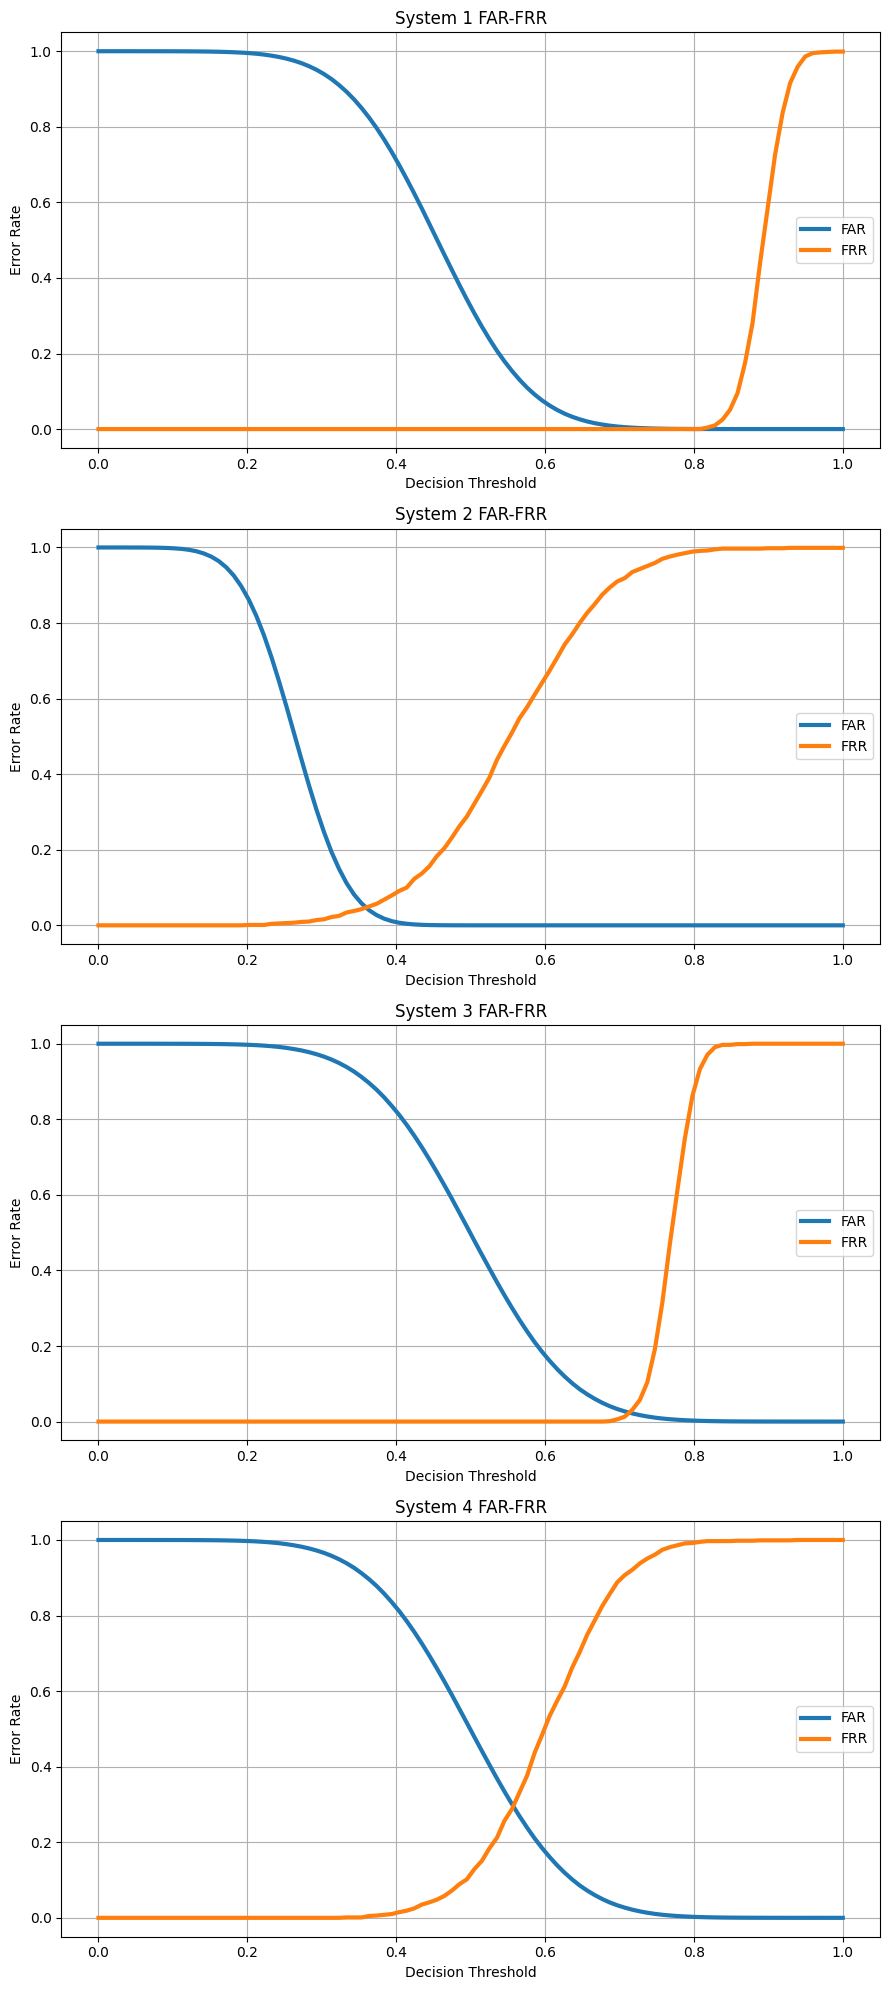

In [38]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR 
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 20))
for i in range(4):
    plt.subplot(4, 1, i+1)
    FPRsystem = FPRSystemsList[i]
    FRRsystem = FRRSystemsList[i]
    # Plot FPR and FRR
    plt.plot(thresholds, FPRsystem, label='FAR', linewidth=3)
    plt.plot(thresholds, FRRsystem, label='FRR', linewidth=3)
    # Add titles and labels for clarity
    plt.title(f'System {i+1} FAR-FRR')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

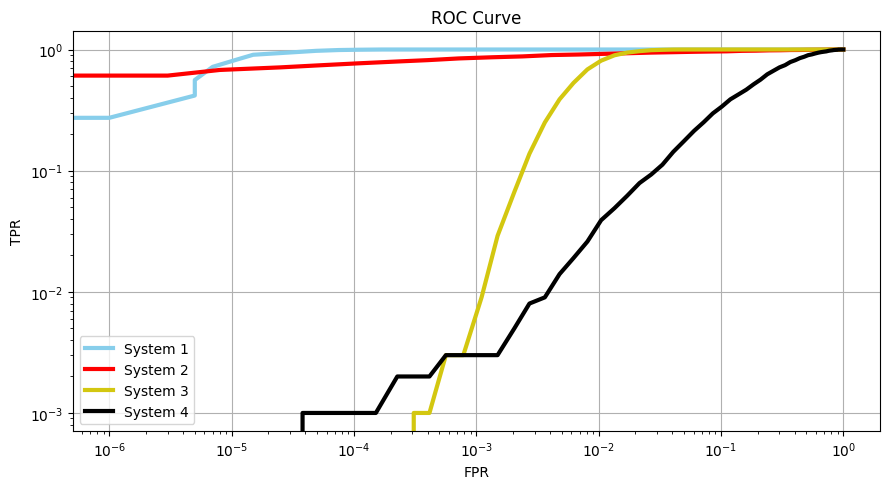

In [39]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9,5))
# Color dict for plotting
for i, (color, _, _, _) in enumerate(systems):
    FPRsystem = FPRSystemsList[i]
    TPRsystem = TPRSystemsList[i]
    # Plot TPR vs FPR
    plt.plot(FPRsystem, TPRsystem, color=color, label=f'System {i+1}', linewidth=3)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid(True)
# Set the x-axis to log scale
plt.xscale('log')
plt.yscale("log")
plt.tight_layout() 
plt.show()

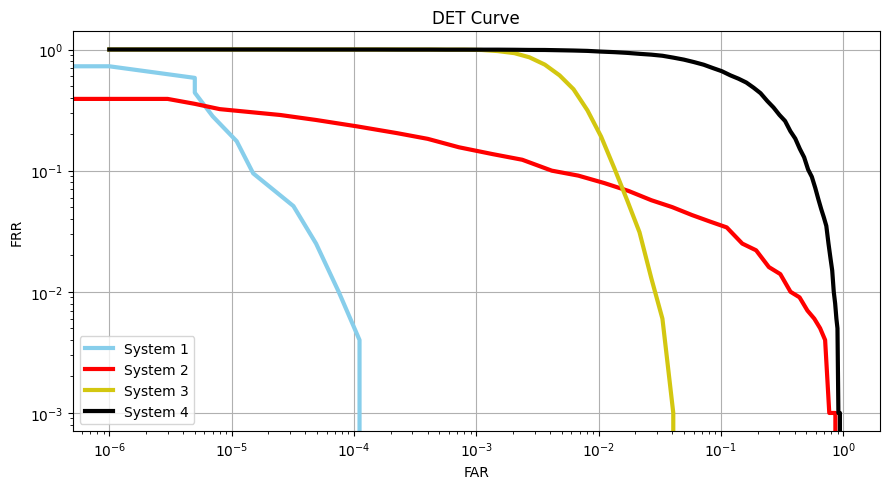

In [40]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5)) 
for i, (color, _, _, _) in enumerate(systems):
    FPRsystem = FPRSystemsList[i]
    FRRsystem = FRRSystemsList[i]
    # Plot FRR vs FAR
    plt.plot(FPRsystem, FRRsystem, color=color, label=f'System {i+1}', linewidth=3)
    plt.title('DET Curve')
    plt.xlabel('FAR')
    plt.ylabel('FRR')
    plt.grid(True)
    plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score for the four systems<b> in a single plot </b>.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


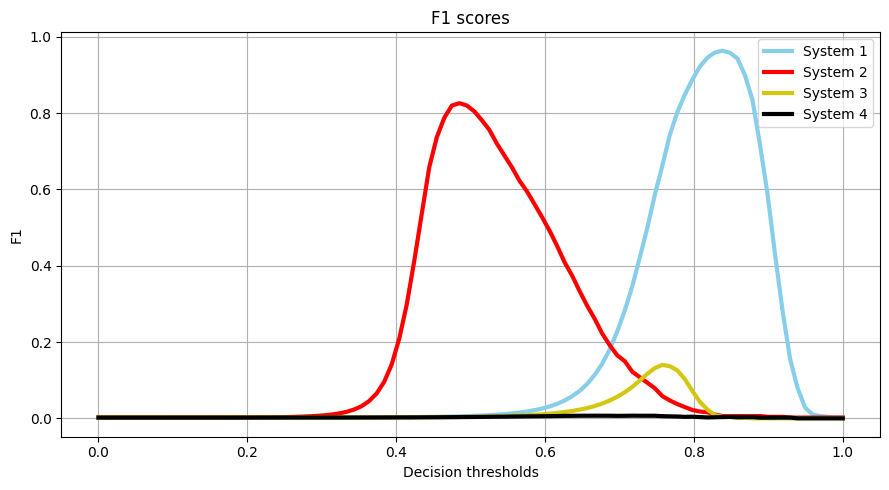

In [42]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
thresholds = np.linspace(0, 1, 100) 
plt.figure(figsize=(9, 5)) 
for i, (color, _, _, _) in enumerate(systems):
    f1 = f1SystemsList[i]
    plt.plot(thresholds, f1, color=color, label=f'System {i+1}', linewidth=3)
    plt.title('F1 scores')
    plt.xlabel('Decision thresholds')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)
plt.tight_layout() 
plt.show()

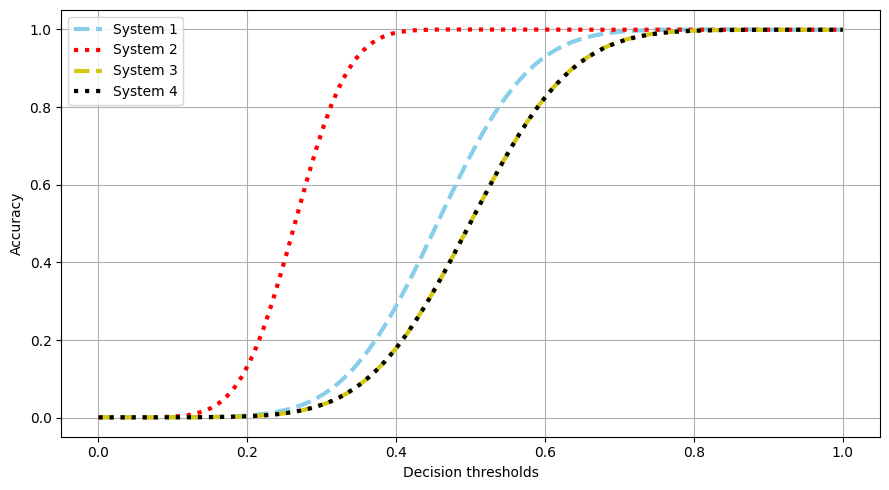

In [43]:
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(9, 5)) 
for i, (color, linstyle, _, _) in enumerate(systems):
    acc = accSystemsList[i]
    plt.plot(thresholds, acc, color=color, label=f'System {i+1}', linestyle=linstyle, linewidth=3)
    plt.xlabel('Decision thresholds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
"""Calculate the threshold for which F1 is maximal."""
for i in range(4):
    # Find max f1
    f1max = np.max(f1SystemsList[i])
    # Get accList for the system
    tempAcc = accSystemsList[i]
    # Get index for max F1
    idxMax = f1SystemsList[i].index(f1max)
    # Print Max F1, its threshold and the respectively accuracy
    print(f"For system {i+1} the max f1 is {f1max:.3f} for the threshold {thresholds[idxMax]:.2f} and accuracy {tempAcc[idxMax]:.3f}")

For system 1 the max f1 is 0.963 for the threshold 0.84 and accuracy 1.000
For system 2 the max f1 is 0.826 for the threshold 0.48 and accuracy 1.000
For system 3 the max f1 is 0.140 for the threshold 0.76 and accuracy 0.992
For system 4 the max f1 is 0.007 for the threshold 0.72 and accuracy 0.978


In [45]:
"""Do the same for the classification error (or accuracy)"""
for i in range(4):
    accMax = np.max(accSystemsList[i])
    tempF1 = f1SystemsList[i]
    idxMax = accSystemsList[i].index(accMax)
    print(f"For system {i+1} the max accuracy is {accMax:.3f} for the threshold {thresholds[idxMax]:.2f} and f1 {tempF1[idxMax]:.3f}")

For system 1 the max accuracy is 1.000 for the threshold 0.84 and f1 0.963
For system 2 the max accuracy is 1.000 for the threshold 0.48 and f1 0.826
For system 3 the max accuracy is 0.999 for the threshold 1.00 and f1 0.000
For system 4 the max accuracy is 0.999 for the threshold 1.00 and f1 0.000


#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Discuss the importance of the FRR and the FAR if you want a very secure versus a very convenient system. </li> 
</ul>  
</div>


In [46]:
"""Calculate the ROC AUC."""
from sklearn.metrics import roc_auc_score
for i, (_, _, genuineID, scores) in enumerate(systems):
    print(f"The ROC AUC for system {i+1} is {roc_auc_score(genuineID, scores):.4f}") 

The ROC AUC for system 1 is 1.0000
The ROC AUC for system 2 is 0.9868
The ROC AUC for system 3 is 0.9927
The ROC AUC for system 4 is 0.7691


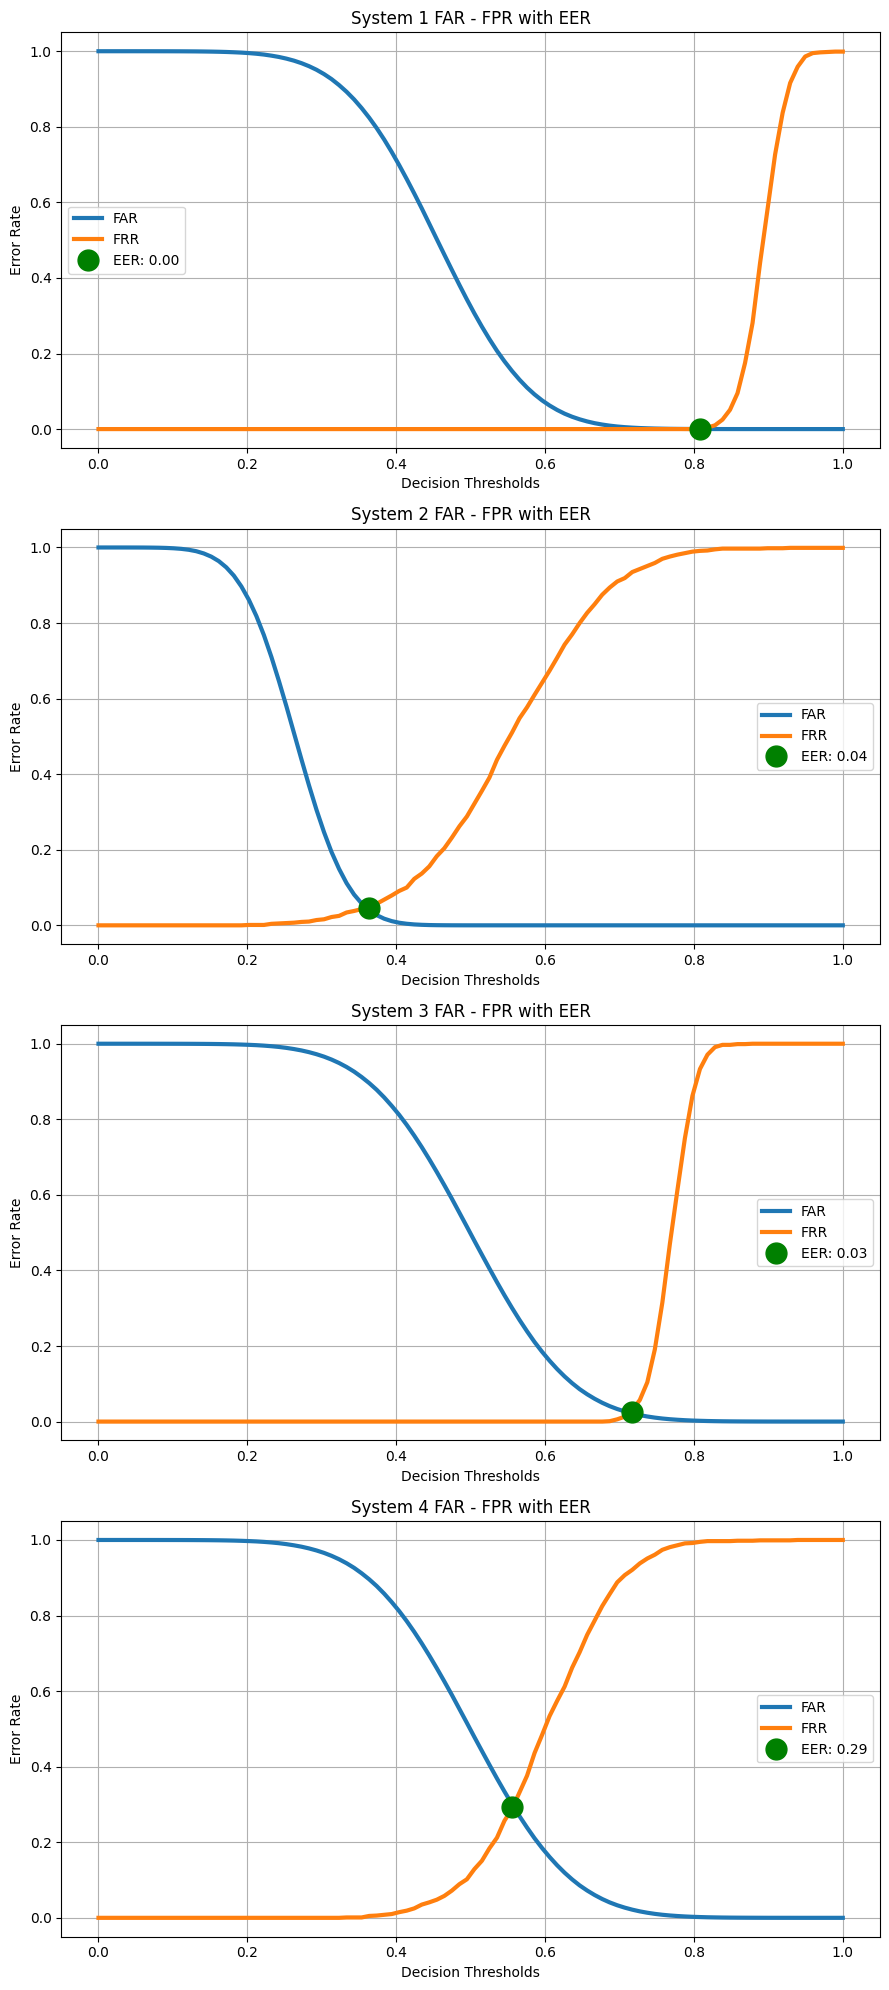

In [51]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 
# Find the minimum difference between FAR and FRR
plt.figure(figsize=(9, 20))
for i in range(4):
    plt.subplot(4, 1, i+1)
    # Get differences
    diffs = np.abs(np.array(FPRSystemsList[i])-np.array(FRRSystemsList[i]))
    # Find min index
    minIdx = np.argmin(diffs)
    # Average at closest point
    EER = (FPRSystemsList[i][minIdx]+FRRSystemsList[i][minIdx])/2
    plt.plot(thresholds, FPRSystemsList[i], label='FAR', linewidth=3)
    plt.plot(thresholds, FRRSystemsList[i], label='FRR', linewidth=3)
    # Mark EER
    plt.plot(thresholds[minIdx], EER, 'go', markersize=15, label=f'EER: {EER:.2f}')
    plt.title(f'System {i+1} FAR - FPR with EER')
    plt.xlabel('Decision Thresholds')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above
for i in range(4):
    # Get sums
    sums = np.array(FPRSystemsList[i]) + np.array(FRRSystemsList[i])
    # Get index for min
    minSumIdx = np.argmin(sums)
    # Find the threshold
    optimalThresh = thresholds[minSumIdx]
    print(f"The minimal sum of FRR and FAR is {sums[minSumIdx]:.3f} for the threshold {optimalThresh:.2f}")

The minimal sum of FRR and FAR is 0.000 for the threshold 0.81
The minimal sum of FRR and FAR is 0.084 for the threshold 0.37
The minimal sum of FRR and FAR is 0.039 for the threshold 0.70
The minimal sum of FRR and FAR is 0.581 for the threshold 0.54


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">

<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for these systems. What does it reveal about the performance of the systems?</li>
    <li>Does the ROC curve or the PRC curve make more sense to evaluate these four systems? (Tip: read the webpages mentioned above). </li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


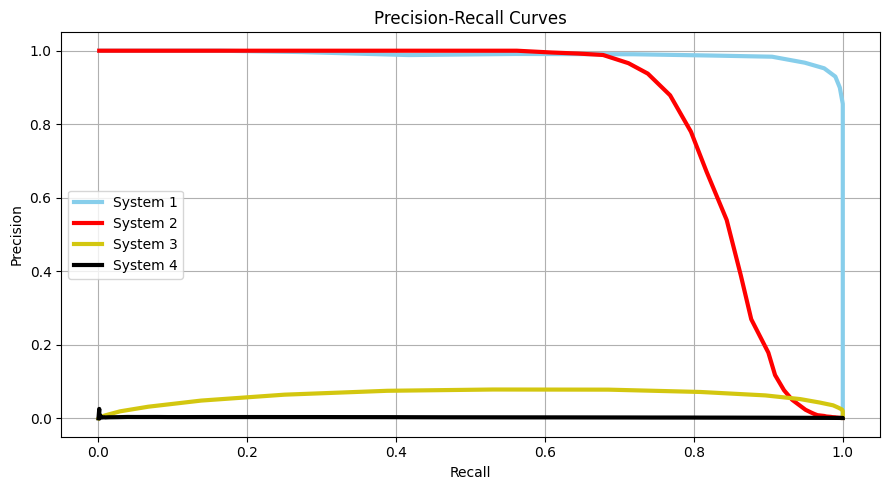

In [53]:
"""Calculate and plot the Precision-Recall curve for the systems"""
plt.figure(figsize=(9, 5))
for i, (color, _, _, _) in enumerate(systems):
    precision = precSystemsList[i]
    recall = recallSystemsList[i]
    plt.plot(recall, precision, label=f'System {i+1}', color=color, linewidth=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
"""Calculate the Area Under the PR-curve."""
from sklearn.metrics import auc
for i in range(4):
    area = auc(recallSystemsList[i], precSystemsList[i])
    print(f"System {i+1} Area Under the PR Curve: {area:.4f}")

System 1 Area Under the PR Curve: 0.9883
System 2 Area Under the PR Curve: 0.8392
System 3 Area Under the PR Curve: 0.0632
System 4 Area Under the PR Curve: 0.0028


In [56]:
"""Calculate the average precision scores"""
from sklearn.metrics import average_precision_score
for i, (_, _, genuineID, scores) in enumerate(systems):
    avgPrecision = average_precision_score(genuineID, scores)
    print(f"System {i+1} Average Precision Score: {avgPrecision:.4f}")

System 1 Average Precision Score: 0.9893
System 2 Average Precision Score: 0.8405
System 3 Average Precision Score: 0.0637
System 4 Average Precision Score: 0.0028


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


In [57]:
def calcCMC(similarityMatrix):
    # Number of individuals for comparisons
    numQueries = similarityMatrix.shape[0]
    # Initialize rank-storing array
    cmcCounts = np.zeros(numQueries)
    for i in range(numQueries):
        # Sort scores for the i-th query in descending order
        sortedIdx = np.argsort(similarityMatrix[i])[::-1] # [::-1] reverses it
        # Find the rank of the genuine score in the diag elmnt
        rank = np.where(sortedIdx == i)[0][0]
        # Increment the CMC count for all positions from the genuine rank onwards
        cmcCounts[rank:] += 1
    # Normalize by the number of queries (elmnts in row) to get probabilities
    cmcCurve = cmcCounts / numQueries
    return cmcCurve

In [58]:
# Create list of similarity matrices
systemMatrices = [system1_similarity_matrix, system2_similarity_matrix, system3_similarity_matrix, system4_similarity_matrix]

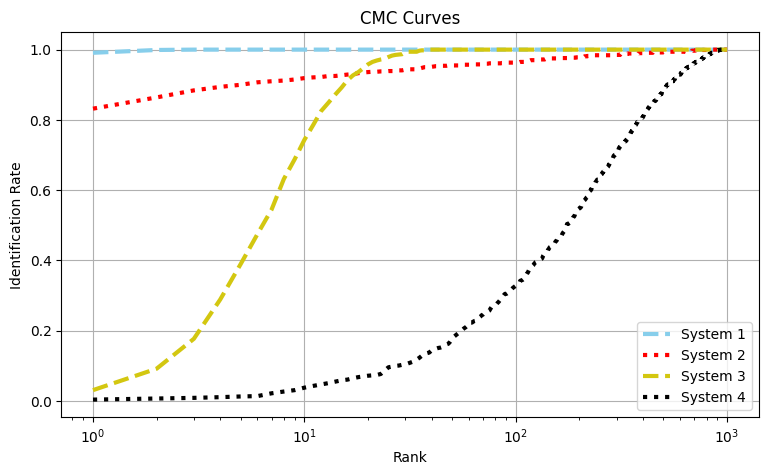

In [59]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library
plt.figure(figsize=(9, 5))
for i, (color, linestyle, _, _)  in enumerate(systems):
    cmcCurve = calcCMC(systemMatrices[i])
    # Create x axis by taking each rank as a point
    x = np.linspace(1, len(cmcCurve), len(cmcCurve))
    plt.plot(x, cmcCurve, linestyle=linestyle, label=f'System {i+1}', color=color, linewidth=3)
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.title(f'CMC Curves')
    plt.xscale("log")
    plt.grid(True)
    plt.legend()
plt.show()

In [60]:
def calcRank1(simMatrix):
    numQueries = simMatrix.shape[0]
    # Initialize count of Rank-1 successes
    rank1Successes = 0
    for i in range(numQueries):
        # Get the scores for the i-th query
        scores = simMatrix[i]
        # Determine if the genuine score is the highest
        if np.argmax(scores) == i:
            rank1Successes += 1
    # Calculate the Rank-1 Recognition Rate
    rank1RecogRate = rank1Successes/numQueries
    return rank1RecogRate

In [61]:
"""compute the Rank-1 Recognition Rate."""
for i in range(4):
    rank1Rate = calcRank1(systemMatrices[i])
    print(f"System {i+1} Rank-1 Recognition Rate: {rank1Rate}")

System 1 Rank-1 Recognition Rate: 0.991
System 2 Rank-1 Recognition Rate: 0.832
System 3 Rank-1 Recognition Rate: 0.031
System 4 Rank-1 Recognition Rate: 0.004


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Propose a new metric not mentioned in this task to evaluate these four systems. This can be something you come up with yourself by adjusting/combining some of the existing metrics in this task or something you find online. Explain in what way your new method is more/less suited to evaluate these systems </li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. Make sure to compare the performance of the four biometric systems in each question. **The report should be self contained, the notebook functions as supplementary material only!**

Your submission should be a .zip file with the name formatted as Assignment1_[Your student number].zip. You should replace [Your student number] with your r-number, with the r. The deadline is 31/03/2024 11PM

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
